# Research Phase: Advanced EDA and Model Experimentation

In this notebook, we follow a professional ML research workflow:
1. **Load Data**
2. **EDA**: Deep dive into distributions and correlations
3. **Train-Test Split**
4. **Skewness Check**: Assessing the need for transformations
5. **Pipeline Creation**: Power Transformation + Scaling + ElasticNetCV
6. **Evaluation & Feature Importance**
7. **Model Diagnostics**: Residuals and Prediction Analysis
8. **Model Comparison**: Baseline and Alternative models
9. **Feature Selection Experiment**: Testing a reduced model
10. **Final Comparison**: Summary of all model metrics

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from scipy.stats import skew, probplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

### 1. Load Data

In [24]:
url = "https://raw.githubusercontent.com/mlflow/mlflow-example/master/wine-quality.csv"
df = pd.read_csv(url)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### 2. EDA

In [25]:
print("--- Info ---")
df.info()
print("\n--- Missing Values ---")
print(df.isnull().sum())
print("\n--- Describe ---")
df.describe()

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB

--- Missing Values ---
fixed acidity           0
volatile acidity        0
citric acid             0
residual su

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [26]:
# Multicollinearity Check (VIF)
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data.sort_values(by="VIF", ascending=False)

print("VIF Scores (Values > 10 indicate high multicollinearity):")
print(calculate_vif(df.drop('quality', axis=1)))

VIF Scores (Values > 10 indicate high multicollinearity):
                 feature          VIF
7                density  1056.497431
8                     pH   609.861725
10               alcohol   118.707368
0          fixed acidity    92.861483
6   total sulfur dioxide    24.980802
9              sulphates    20.527123
2            citric acid    10.007114
1       volatile acidity     9.730569
5    free sulfur dioxide     9.261556
4              chlorides     6.497448
3         residual sugar     3.830272


In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

In [28]:
# Separating X and y
X = df.drop(["quality"], axis=1)
y = df["quality"]

### 3. Train-Test Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Skewness Check

In [ ]:
skewness = X_train.apply(lambda x: skew(x)).sort_values(ascending=False)
print("Skewness in numerical features:")
print(skewness)

X_train.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

### 5. Create Pipeline (Yeo-Johnson + Scaling + ElasticNetCV)

In [31]:
pipeline = Pipeline([
    ('transform', PowerTransformer(method='yeo-johnson')), 
    ('scaler', StandardScaler()),                         
    ('model', ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
                           alphas=[0.01, 0.1, 1, 10], 
                           cv=5, 
                           random_state=42))
])

pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('transform', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"method method: {'yeo-johnson', 'box-cox'}, default='yeo-johnson'The power transform method. Available methods are:- 'yeo-johnson' [1]_, works with positive and negative values- 'box-cox' [2]_, only works with strictly positive values",'yeo-johnson'
,"standardize standardize: bool, default=TrueSet to True to apply zero-mean, unit-variance normalization to thetransformed output.",True
,"copy copy: bool, default=TrueSet to False to perform inplace computation during transformation.",True
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"l1_ratio l1_ratio: float or list of float, default=0.5Float between 0 and 1 passed to ElasticNet (scaling betweenl1 and l2 penalties). For ``l1_ratio = 0``the penalty is an L2 penalty. For ``l1_ratio = 1`` it is an L1 penalty.For ``0 < l1_ratio < 1``, the penalty is a combination of L1 and L2This parameter can be a list, in which case the differentvalues are tested by cross-validation and the one giving the bestprediction score is used. Note that a good choice of list ofvalues for l1_ratio is often to put more values close to 1(i.e. Lasso) and less close to 0 (i.e. Ridge), as in ``[.1, .5, .7,.9, .95, .99, 1]``.","[0.1, 0.5, ...]"


### 6. Evaluation & Feature Importance

In [37]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

y_pred = pipeline.predict(X_test)
rmse, mae, r2 = eval_metrics(y_test, y_pred)

results_df = pd.DataFrame(columns=["Model", "RMSE", "MAE", "R2"])
results_df.loc[len(results_df)] = ["ElasticNetCV (Full)", rmse, mae, r2]

best_model = pipeline.named_steps['model']
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
print(f"Best Alpha: {best_model.alpha_}")
print(f"Best L1 Ratio: {best_model.l1_ratio_}")

RMSE: 0.7512, MAE: 0.5865, R2: 0.2713
Best Alpha: 0.01
Best L1 Ratio: 0.1


### 7. Model Diagnostics (The "Pro" Step)

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(15, 5))

# 1. Residual Plot
plt.subplot(1, 3, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# 2. Residual Distribution
plt.subplot(1, 3, 2)
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')

# 3. Prediction vs Actual
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

plt.tight_layout()
plt.show()

### 8. Model Comparison

In [34]:
models = {
    "Baseline (Mean)": DummyRegressor(strategy="mean"),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse, mae, r2 = eval_metrics(y_test, predictions)
    results_df.loc[len(results_df)] = [name, rmse, mae, r2]
    print(f"{name} - R2: {r2:.4f}, RMSE: {rmse:.4f}")

Baseline (Mean) - R2: -0.0014, RMSE: 0.8806
Linear Regression - R2: 0.2653, RMSE: 0.7543
Random Forest - R2: 0.5510, RMSE: 0.5897


### 9. Feature Selection Experiment

In [35]:
drop_cols = ["density", "pH", "citric acid"]
X_train_reduced = X_train.drop(columns=drop_cols)
X_test_reduced = X_test.drop(columns=drop_cols)

pipeline_reduced = Pipeline([
    ("yeo", PowerTransformer()),
    ("scaler", StandardScaler()),
    ("enet", ElasticNetCV(cv=5, random_state=42))
])

pipeline_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = pipeline_reduced.predict(X_test_reduced)
rmse, mae, r2 = eval_metrics(y_test, y_pred_reduced)

results_df.loc[len(results_df)] = ["ElasticNetCV (Reduced)", rmse, mae, r2]
print(f"ElasticNetCV (Reduced) - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

ElasticNetCV (Reduced) - RMSE: 0.7624, MAE: 0.5934, R2: 0.2495


### 10. Final Comparison Summary


--- Final Model Comparison Summary ---


,Model,RMSE,MAE,R2
3,Random Forest,0.589708,0.418520,0.550978
0,ElasticNetCV (Full),0.751226,0.586539,0.271324
2,Linear Regression,0.754337,0.586267,0.265275
4,ElasticNetCV (Reduced),0.762391,0.593387,0.249503
1,Baseline (Mean),0.880650,0.674979,-0.001382


/var/folders/lv/gylq_5hs2cd1bw7y0hdmkl3h0000gn/T/ipykernel_87962/2178790284.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.sort_values(by="R2", ascending=False), x="R2", y="Model", palette="viridis")


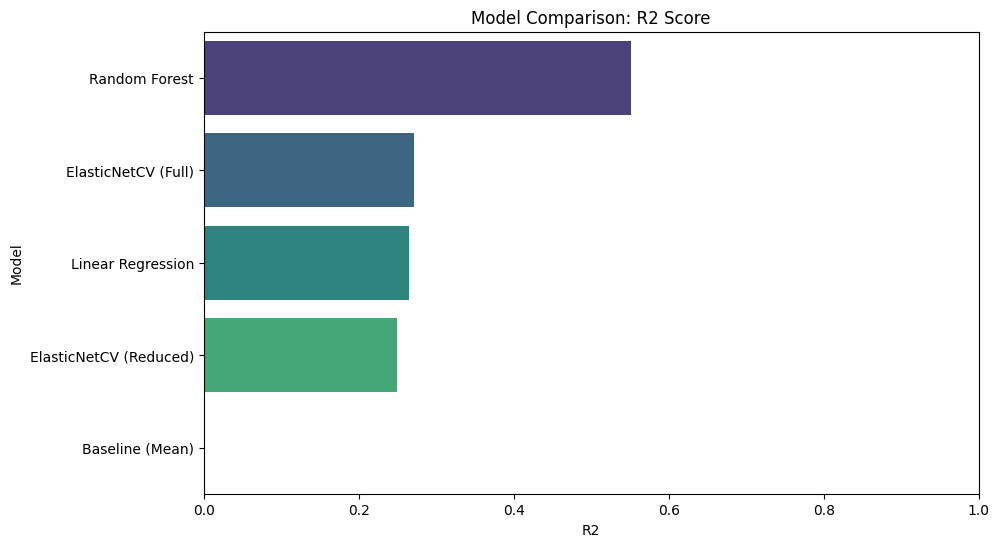

In [36]:
print("\n--- Final Model Comparison Summary ---")
display(results_df.sort_values(by="R2", ascending=False))

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.sort_values(by="R2", ascending=False), x="R2", y="Model", palette="viridis")
plt.title("Model Comparison: R2 Score")
plt.xlim(0, 1)
plt.show()